# Santander Customer Transaction Prediction

In this notebook, we solve a Kaggle challenge by the Santander Bank.
We are given the transaction history of various customers and want to predict which customers  will make a specific transaction in the future.
The previous transactions of a customer are represented by 200 numeric feature variables (`var_1, var_2, ..., var_199`).
For the training set, we know whether a customer makes the speficic transaction that we want to learn (`target=1`) or does not make it (`target=0`).
The precise description of the challenge can be found [here](https://www.kaggle.com/c/santander-customer-transaction-prediction/data?select=sample_submission.csv).
We first explore the data and then use the popular gradient boosting framework [XGBoost](https://en.wikipedia.org/wiki/XGBoost) to make our predictions. For this challenge, we measure the performance of our model using [AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). We archive an AUC of 0.872. The currently best score on the [leaderboard](https://www.kaggle.com/c/santander-customer-transaction-prediction/leaderboard) is 0.927.

If you have Docker installed, you can easily run this notebook yourself by following these steps:

- `git clone git@github.com:mojgankamali67/Kaggle.git`
- `cd Kaggle/Santander`
- `docker build -t santander .` 
- `docker run --rm -p 8888:8888 santander`
- open `localhost:8888/notebooks/Santander.ipynb` in your web browser.

We start by loading the required packages, in particular `seaborn` for visualization and `xgboost` for gradient boosting.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## Exploratory Data Analysis

At first, we explore the data and visualize some basic statistics.
The dataset consists of 200000 rows (customers with ID_code), each having 200 features (representing transactions that customers have done in the past). The target column shows whether a customer will do the transaction we want to predict (1) or not (0).


In [2]:
data = pd.read_csv('data/train.csv')
data.shape

(200000, 202)

A quick peak into the data looks like this:

In [3]:
data.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

We check for null or missing values and see that there are none.

In [4]:
data.isnull().sum().sum()

0

Let's check some basic statistics of our data set. It seems like the data has already been normalized.

In [5]:
data.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

To get some intuition on our data, we plot the distribution of the first 10 features of our data set.
We see that the distibutions are bell-shaped, with one or sometimes two peaks.

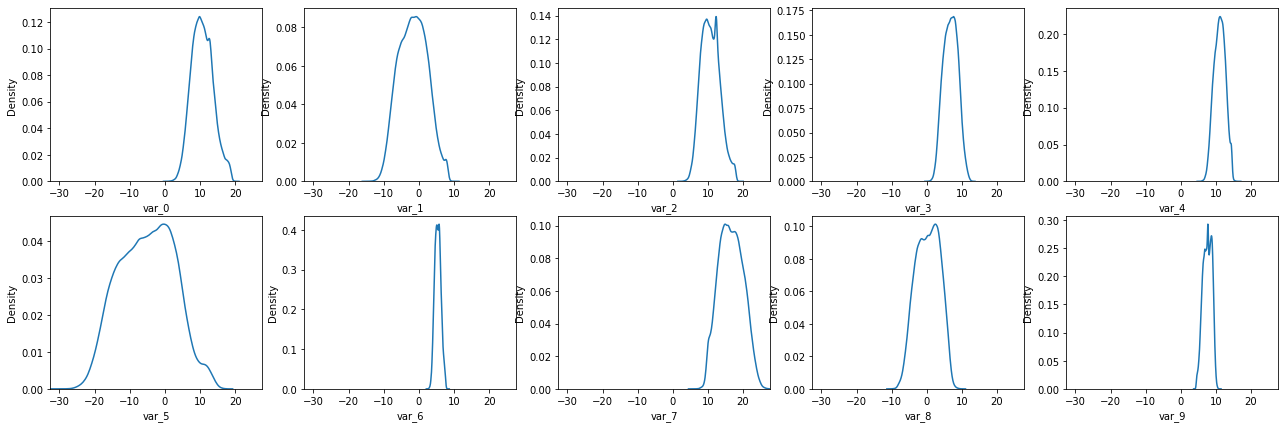

In [6]:
min_value_slice = data[data.columns[2:12]].min().min()
max_value_slice = data[data.columns[2:12]].max().max()
fig, ax = plt.subplots(figsize=(22,7))
i = 0
for feature in data.columns[2:12] :
    i = i + 1
    plt.subplot(2,5,i)
    sns.distplot(data[feature], hist = False)
    plt.xlim(min_value_slice, max_value_slice)
plt.show()

Next, we check for correlation between different features. The plot shows that there is almost no correlation.

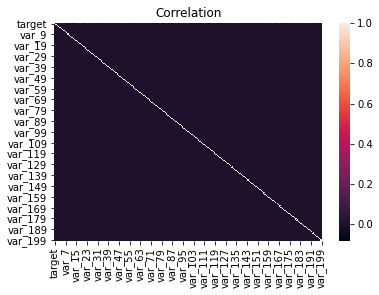

In [7]:
sns.heatmap(data.corr(), annot = False).set_title("Correlation")
plt.show()

We notice that our dataset is quite imbalanced. Only 10% of the customers make the transaction that we want to predict.

Percentage of 1: 10.049 %


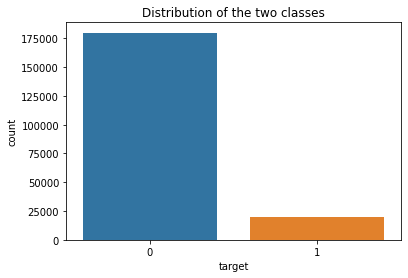

In [8]:
print("Percentage of 1: {} %".format(data.target.value_counts()[1]/data.shape[0] * 100))
sns.countplot(x=data.target).set_title("Distribution of the two classes")
plt.show()

Next, we want to analyze to what extend the distributions of the features differ between the two target classes (target=1 and target=0).
To this end, we plot the distributions of the features for both classes separately.
While for some features the distributions do not differ (e.g., `var_4`), for other features they differ significantly (e.g., `var_13`). 
It is therefore reasonable to assume that `var_13` will have a stronger impact on our prediction than `var_4`.

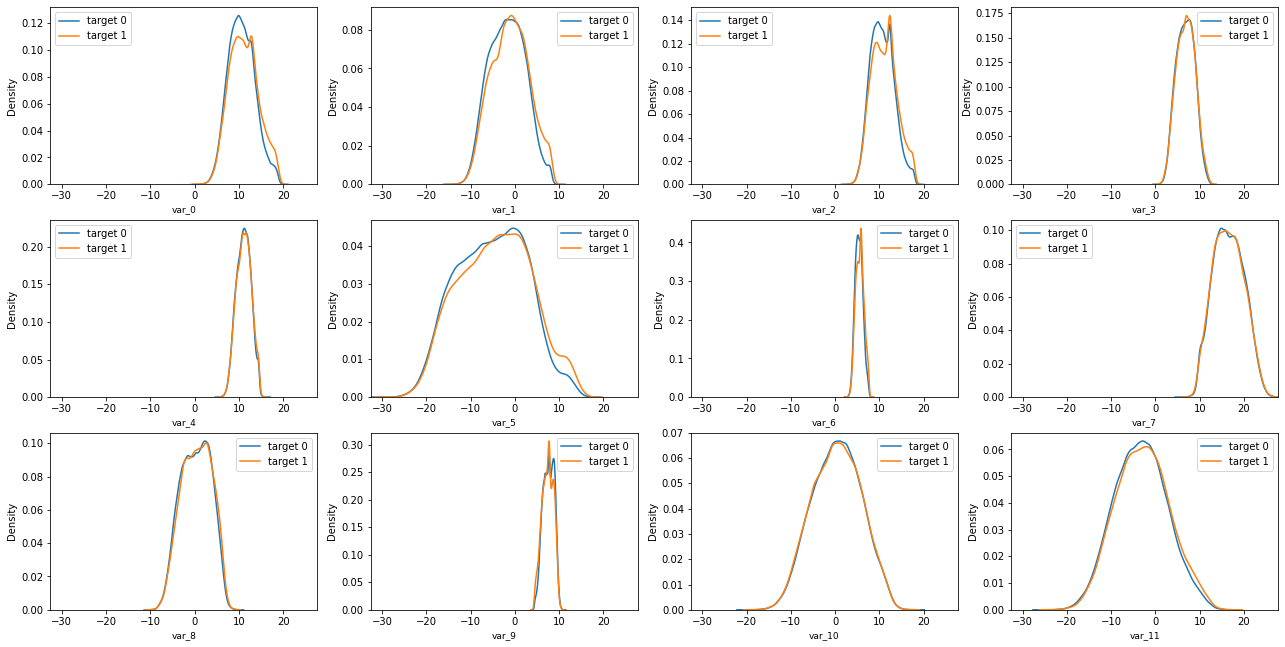

In [9]:
i = 0
fig, ax = plt.subplots(figsize=(22,15))

for feature in data.columns[2:14] :
    i = i + 1
    plt.subplot(4,4,i) 
    sns.distplot(data.loc[data.target==0][feature], hist=False, label="target 0")
    sns.distplot(data.loc[data.target==1][feature], hist=False, label="target 1")

    plt.xlim(min_value_slice, max_value_slice)
    plt.xlabel(feature, fontsize=9)
    plt.legend()
plt.show()

## Gradient Boosting


We observed earlier that the features are already normalized and not correlated, so we do not have to normalize or decorrelate them.
To get an overview which hyperparameters of the `XGBClassifier` work well for our problem, we perform a small randomized search.


In [10]:
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    "max_depth"        : [2,3,4],
    "n_estimators"     : [50],
    "learning_rate"    : [1],
    "min_child_weight" : [1, 10, 20],
    "gamma"            : [0.0, 0.2 , 0.4],
    "colsample_bytree" : [0.3, 0.7]
}
random_search  = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 2,
    verbose=True
)
x,y = data[data.columns[2:]], data['target']
random_search.fit(x,y)
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[21:02:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'n_estimators': 50, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 1, 'gamma': 0.0, 'colsample_bytree': 0.3}
0.8413112244316421


This gives us a good overview which parameters seem to work.
After some more manual experiments, we arrive at the following parameters.
We use 300 estimators of depth 2 with `min_child_weight = 20`, `gamma = 0.4` and `colsample_bytree = 0.3`.
We also add a scheduler that reduces the learning rate after 200 iterations.
We train and evaluate this classifier on a 80%-20% train-test split.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data[data.columns[2:]], data['target'], test_size=0.2, random_state=0)

params = {
    'max_depth': 2,
    'n_estimators': 300,
    'learning_rate': 1,
    'objective': 'binary:logistic',
    'min_child_weight': 20,
    'gamma': 0.4,
    'colsample_bytree': 0.3,
    'nthread' : 4,
    }
model = xgb.XGBClassifier(**params)

def learning_rate_callback(n):
    if n < 200: return 1
    return 0.3

model.fit(
    x_train, 
    y_train,
    eval_metric = 'auc',
    eval_set = [(x_train,y_train), (x_test,y_test)],
    callbacks = [xgb.callback.LearningRateScheduler(learning_rate_callback)],
    verbose = True)

model.save_model('model')

[0]	validation_0-auc:0.57646	validation_1-auc:0.57342
[1]	validation_0-auc:0.62252	validation_1-auc:0.61778
[2]	validation_0-auc:0.64450	validation_1-auc:0.63489
[3]	validation_0-auc:0.66171	validation_1-auc:0.65198
[4]	validation_0-auc:0.67351	validation_1-auc:0.66389
[5]	validation_0-auc:0.68642	validation_1-auc:0.67611
[6]	validation_0-auc:0.70106	validation_1-auc:0.69800
[7]	validation_0-auc:0.71382	validation_1-auc:0.70780
[8]	validation_0-auc:0.72325	validation_1-auc:0.71630
[9]	validation_0-auc:0.73197	validation_1-auc:0.72306
[10]	validation_0-auc:0.73972	validation_1-auc:0.72937
[11]	validation_0-auc:0.74747	validation_1-auc:0.73677
[12]	validation_0-auc:0.75479	validation_1-auc:0.74273
[13]	validation_0-auc:0.76285	validation_1-auc:0.75031
[14]	validation_0-auc:0.76826	validation_1-auc:0.75570
[15]	validation_0-auc:0.77450	validation_1-auc:0.75967
[16]	validation_0-auc:0.77937	validation_1-auc:0.76411
[17]	validation_0-auc:0.78377	validation_1-auc:0.77032
[18]	validation_0-au

In the end, we achieve an AUC of 0.872. In the future, one may perform a more exhaustive hyperparameter search or data augmentation to improve our score.

In [12]:
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(x_test)[:,1]), "\n")
print("Classification Report")
print(classification_report(y_test, model.predict(x_test)))

ROC AUC: 0.872401016217595 

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     35986
           1       0.61      0.40      0.48      4014

    accuracy                           0.91     40000
   macro avg       0.77      0.68      0.72     40000
weighted avg       0.90      0.91      0.91     40000

